In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

### Part 1: Read in the data

In [2]:
path= '/Users/philhuang/Desktop/Phil_projects/P5_PhilHuang/workingdata/'

file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

# concat the sub-files together
df=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])
df.shape

(2071611, 108)

In [3]:
# check unique loan ID
df['LOAN_ID'].nunique()

104924

### Part 2: Find the loan age when a mortgage gets terminated
* There are two types of termination: 
** voluntary prepayment: rate refinance or cash out refinance
** involuntary prepayment: serious payment default (bucket 6 or above)

### involuntary termination - prepayment default
* Here we will use a very loose definition. 
* Actual termination usually involves foreclosure, which is more serious than no payment received for 6 months. 

In [4]:
# mark those loans with bucket six and above
df['bad']=np.where(df['DLQ_STATUS'] >= 6, 1, 0)

In [5]:
# find the row with earliest year of 'bad' for each LOAN ID
# take 'bad' loans out
df_bad = copy.deepcopy(df[df['bad']==1])

# for each loan, we keep the minimum age of the loan, which is the age when the loan
# had buckt six
df_bad = df_bad.loc[df_bad.groupby('LOAN_ID')['LOAN_AGE'].idxmin()].reset_index()

# drop duplicates just in case
df_bad=df_bad.drop_duplicates(subset='LOAN_ID', keep='first')

In [6]:
# look at the data
df_bad[['LOAN_ID', 'bad', 'LOAN_AGE']]

,LOAN_ID,bad,LOAN_AGE
0,98836805,1,9.0
1,98837212,1,8.0
2,98838094,1,13.0
3,98838634,1,28.0
4,98838095,1,9.0
...,...,...,...
2546,99518403,1,13.0
2547,99518443,1,8.0
2548,99518840,1,15.0
2549,99519162,1,6.0


In [7]:
df_bad[['LOAN_ID', 'LOAN_AGE', 'bad']].count()

LOAN_ID     2469
LOAN_AGE    2469
bad         2469
dtype: int64

In [8]:
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2550
Columns: 110 entries, index to bad
dtypes: float64(75), int64(13), object(22)
memory usage: 2.1+ MB


In [9]:
# get those loans without 'bad'
df_good=pd.merge(df[['LOAN_ID', 'LOAN_AGE']], df_bad[['LOAN_ID', 'bad']], on='LOAN_ID', how='left')
df_good=df_good[df_good['bad'] != 1]
df_good['bad']=0

In [10]:
# find the maximum loan age for good accounts
df_good = copy.deepcopy(df_good.loc[df_good.groupby('LOAN_ID')['LOAN_AGE'].idxmax()].reset_index())
df_good = df_good.drop_duplicates(subset='LOAN_ID', keep='first')

In [11]:
# check the data 
df_good

,index,LOAN_ID,LOAN_AGE,bad
0,1107557,98836742,9.0,0
1,7,98836743,7.0,0
2,33,98836744,23.0,0
3,1586592,98836781,25.0,0
4,1107585,98836789,26.0,0
...,...,...,...,...
102450,2071599,99520412,23.0,0
102451,2071609,99520417,9.0,0
102452,1107526,99520428,25.0,0
102453,339551,99520430,24.0,0


In [12]:
# check the dataset
df_good[['LOAN_ID', 'LOAN_AGE', 'bad']].count()

LOAN_ID     102455
LOAN_AGE    102455
bad         102455
dtype: int64

In [13]:
df_good['LOAN_AGE'].count()

102455

In [14]:
# stack two files
df_bad = pd.concat([df_good, df_bad[['LOAN_ID', 'bad', 'LOAN_AGE']]]).reset_index(drop=True)
df_bad

,index,LOAN_ID,LOAN_AGE,bad
0,1107557.0,98836742,9.0,0
1,7.0,98836743,7.0,0
2,33.0,98836744,23.0,0
3,1586592.0,98836781,25.0,0
4,1107585.0,98836789,26.0,0
...,...,...,...,...
104919,NaN,99518403,13.0,1
104920,NaN,99518443,8.0,1
104921,NaN,99518840,15.0,1
104922,NaN,99519162,6.0,1


In [15]:
# check the dataset
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104924 entries, 0 to 104923
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   index     102455 non-null  float64
 1   LOAN_ID   104924 non-null  int64  
 2   LOAN_AGE  104924 non-null  float64
 3   bad       104924 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.2 MB


In [16]:
df_bad['LOAN_ID'].nunique()

104924

In [17]:
df_bad['bad'].count()

104924

In [18]:
df_bad.drop(columns=['index'], inplace=True)
df_bad

,LOAN_ID,LOAN_AGE,bad
0,98836742,9.0,0
1,98836743,7.0,0
2,98836744,23.0,0
3,98836781,25.0,0
4,98836789,26.0,0
...,...,...,...
104919,99518403,13.0,1
104920,99518443,8.0,1
104921,99518840,15.0,1
104922,99519162,6.0,1


In [19]:
# some loan age are negative, we change them to 0
df_bad['LOAN_AGE']=np.where(df_bad['LOAN_AGE'] < 0, 0, df_bad['LOAN_AGE'])

# make a copy of the file
df_bad = copy.deepcopy(df_bad)

### voluntary termination - prepayment

In [20]:
# check the 'zero_Bal_Code', which is a code indicating the reason the loan's balance was reduced to zero 
# or experienced a credit event,
df.groupby('Zero_Bal_Code')['LOAN_ID'].count()

Zero_Bal_Code
1.0     54061
2.0         3
6.0        98
9.0         4
16.0        5
Name: LOAN_ID, dtype: int64

In [21]:
# construct a dummy for prepayment
df['prepaid']=np.where(df['Zero_Bal_Code'] > 0, 1, 0)

In [22]:
# we noticed that some 'loan_age' variable is missing. and we want to figure out why 
null_age_loans = df[df['LOAN_AGE'].isnull()]['LOAN_ID'].to_list()

In [23]:
df[df['LOAN_ID']==null_age_loans[0]][['LOAN_ID', 'LOAN_AGE', 'ORIG_UPB', 'CURRENT_UPB', 'Zero_Bal_Code']]

,LOAN_ID,LOAN_AGE,ORIG_UPB,CURRENT_UPB,Zero_Bal_Code
0,98836743,0.0,207000.0,206411.45,NaN
1,98836743,1.0,207000.0,205821.12,NaN
2,98836743,2.0,207000.0,205229.01,NaN
3,98836743,3.0,207000.0,204635.11,NaN
4,98836743,4.0,207000.0,204039.42,NaN
5,98836743,5.0,207000.0,203441.93,NaN
6,98836743,6.0,207000.0,203000.00,NaN
7,98836743,7.0,207000.0,202842.63,NaN
8,98836743,NaN,207000.0,0.00,1.0


In [24]:
df[df['LOAN_ID']==null_age_loans[1]][['LOAN_ID', 'LOAN_AGE', 'ORIG_UPB', 'CURRENT_UPB', 'Zero_Bal_Code']]

,LOAN_ID,LOAN_AGE,ORIG_UPB,CURRENT_UPB,Zero_Bal_Code
9,98836744,-1.0,215000.0,215000.00,NaN
10,98836744,0.0,215000.0,215000.00,NaN
11,98836744,1.0,215000.0,214383.86,NaN
12,98836744,2.0,215000.0,213765.86,NaN
13,98836744,3.0,215000.0,213145.99,NaN
14,98836744,4.0,215000.0,212524.25,NaN
15,98836744,5.0,215000.0,212000.00,NaN
16,98836744,6.0,215000.0,211000.00,NaN
17,98836744,7.0,215000.0,210647.74,NaN
18,98836744,8.0,215000.0,209968.46,NaN


* Finding: when the loan is paid off, LOAN_AGE becomes zero
* We can use (preiouvs LOAN_AGE)+1 as the LOAN_AGE for complete prepayment

In [25]:
# take out the prepayment loans
df_prepaid = copy.deepcopy(df[df['prepaid']==1])

In [26]:
# we can check now that all the 'loan_age' is NaN
np.sum(~df_prepaid['LOAN_AGE'].isnull())

0

In [27]:
# Take out the loans that are prepaid. Since we have the list for the loans that are prepaid, 
# we merge it wth the original dataset.
df_prepaid = pd.merge(df_prepaid[['LOAN_ID']], df, on='LOAN_ID', how='left')

In [28]:
# get the maximun age of each loan 
df_prepaid = copy.deepcopy(df_prepaid.groupby('LOAN_ID')['LOAN_AGE'].max().reset_index())

In [29]:
# we add one year to the age of the loan, since the prepayment happens in the last month and the 
# corresponding age is nan
df_prepaid['LOAN_AGE'] = df_prepaid['LOAN_AGE']+1

In [30]:
# check the data. This contains all the loans that are prepaid.
df_prepaid

,LOAN_ID,LOAN_AGE
0,98836742,10.0
1,98836743,8.0
2,98836744,24.0
3,98836799,5.0
4,98836817,14.0
...,...,...
54166,99520341,20.0
54167,99520350,9.0
54168,99520391,16.0
54169,99520399,7.0


In [31]:
# carve out those loans that have not been prepaid 
# we first merge the prepaid loans to the original df, and assign a new column 'prepaid' which equals 1
df_unprepaid=pd.merge(df_prepaid[['LOAN_ID']].assign(prepaid=1), 
                      df[['LOAN_ID', 'LOAN_AGE']], 
                      on='LOAN_ID', how='right')

# for those unprepaid loan, we should observe that the 'prepaid' column is null
df_unprepaid=copy.deepcopy(df_unprepaid[df_unprepaid['prepaid'].isnull()])

# get the maximum age pf these unpaid loans
df_unprepaid=copy.deepcopy(df_unprepaid.groupby('LOAN_ID')['LOAN_AGE'].max().reset_index())

In [32]:
# let the 'prepaid' indicator for these loans to be 0
df_unprepaid['prepaid']=0

In [33]:
# check the summary statistics
df_unprepaid.describe()

,LOAN_ID,LOAN_AGE,prepaid
count,5.075300e+04,50753.000000,50753.0
mean,9.918886e+07,24.998995,0.0
std,1.970546e+05,1.367384,0.0
min,9.883678e+07,23.000000,0.0
25%,9.901876e+07,24.000000,0.0
50%,9.919525e+07,25.000000,0.0
75%,9.935945e+07,26.000000,0.0
max,9.952048e+07,36.000000,0.0


In [34]:
# next we concate the prepaid and unprepaid data together
df_prepaid = pd.concat([df_prepaid.assign(prepaid=1), df_unprepaid])

In [35]:
# check the data
df_prepaid.describe()

,LOAN_ID,LOAN_AGE,prepaid
count,1.049240e+05,104924.000000,104924.000000
mean,9.917922e+07,18.894581,0.516288
std,1.970199e+05,7.236594,0.499737
min,9.883674e+07,0.000000,0.000000
25%,9.900946e+07,12.000000,0.000000
50%,9.918055e+07,23.000000,1.000000
75%,9.934903e+07,25.000000,1.000000
max,9.952048e+07,66.000000,1.000000


In [36]:
df_prepaid.head()

,LOAN_ID,LOAN_AGE,prepaid
0,98836742,10.0,1
1,98836743,8.0,1
2,98836744,24.0,1
3,98836799,5.0,1
4,98836817,14.0,1


In [37]:
df_bad.head()

,LOAN_ID,LOAN_AGE,bad
0,98836742,9.0,0
1,98836743,7.0,0
2,98836744,23.0,0
3,98836781,25.0,0
4,98836789,26.0,0


### Merge two files

Now we can get a file of:
* all loans without duplicates
* an indicator of whether this loan is 'bad' or not 
* an indicator of whether this loan gets prepaid or not

In [46]:
df_survival=pd.merge(df_bad.rename(columns={'LOAN_AGE': 'loan_age_bad'}),
                     df_prepaid.rename(columns={'LOAN_AGE': 'loan_age_prepaid'}), 
                     on='LOAN_ID', how='inner')

In [47]:
df_survival

,LOAN_ID,loan_age_bad,bad,loan_age_prepaid,prepaid
0,98836742,9.0,0,10.0,1
1,98836743,7.0,0,8.0,1
2,98836744,23.0,0,24.0,1
3,98836781,25.0,0,25.0,0
4,98836789,26.0,0,26.0,0
...,...,...,...,...,...
104919,99518403,13.0,1,15.0,1
104920,99518443,8.0,1,25.0,0
104921,99518840,15.0,1,24.0,0
104922,99519162,6.0,1,17.0,1


In [48]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 104923
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LOAN_ID           104924 non-null  int64  
 1   loan_age_bad      104924 non-null  float64
 2   bad               104924 non-null  int64  
 3   loan_age_prepaid  104924 non-null  float64
 4   prepaid           104924 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 4.8 MB


Now we want to add the loan-level information to this dataset.

In [49]:
# drop duplicates in the orginal dataset
df_nodup=df.drop_duplicates(subset='LOAN_ID', keep='first')

In [52]:
# merge loan level information to it 
df_survival=pd.merge(df_survival, df_nodup[['LOAN_ID', "ORIG_RATE", "CURR_RATE", "ORIG_UPB", "ORIG_TERM",  
                                            "OLTV", "OCLTV", "DTI", "CSCORE_B", "PURPOSE", "PROP", "STATE"]])

In [53]:
df_survival.describe().T

,count,mean,std,min,25%,50%,75%,max
LOAN_ID,104924.0,9.917922e+07,197019.945107,9.883674e+07,99009455.75,99180553.50,9.934903e+07,99520476.0
loan_age_bad,104924.0,1.808653e+01,7.702378,0.000000e+00,11.00,22.00,2.500000e+01,65.0
bad,104924.0,2.353132e-02,0.151584,0.000000e+00,0.00,0.00,0.000000e+00,1.0
loan_age_prepaid,104924.0,1.889458e+01,7.236594,0.000000e+00,12.00,23.00,2.500000e+01,66.0
prepaid,104924.0,5.162880e-01,0.499737,0.000000e+00,0.00,1.00,1.000000e+00,1.0
ORIG_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.50,3.75,3.999000e+00,6.5
CURR_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.50,3.75,3.999000e+00,6.5
ORIG_UPB,104924.0,2.537213e+05,123826.341576,1.000000e+04,156000.00,237000.00,3.350000e+05,800000.0
ORIG_TERM,104924.0,3.196551e+02,72.642681,9.600000e+01,324.00,360.00,3.600000e+02,360.0
OLTV,104924.0,7.392929e+01,16.254267,7.000000e+00,65.00,76.00,8.500000e+01,97.0


* All mortgages were originated in Q1 2020. By Q3 2022 they are no more than 30 months old.
* Loans showing age > 30 are considered to be data error and should be excluded. 

In [54]:
df_survival.describe(percentiles=(0.90, 0.95, 0.99, 0.995, 0.999, 1)).T

,count,mean,std,min,50%,90%,95%,99%,99.5%,99.9%,100%,max
LOAN_ID,104924.0,9.917922e+07,197019.945107,9.883674e+07,99180553.50,9.945219e+07,9.948628e+07,99513795.70,9.951707e+07,9.951968e+07,99520476.0,99520476.0
loan_age_bad,104924.0,1.808653e+01,7.702378,0.000000e+00,22.00,2.600000e+01,2.700000e+01,28.00,2.900000e+01,3.000000e+01,65.0,65.0
bad,104924.0,2.353132e-02,0.151584,0.000000e+00,0.00,0.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.0,1.0
loan_age_prepaid,104924.0,1.889458e+01,7.236594,0.000000e+00,23.00,2.600000e+01,2.700000e+01,28.00,2.900000e+01,3.000000e+01,66.0,66.0
prepaid,104924.0,5.162880e-01,0.499737,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.00,1.000000e+00,1.000000e+00,1.0,1.0
ORIG_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.75,4.375000e+00,4.625000e+00,5.25,5.500000e+00,5.750000e+00,6.5,6.5
CURR_RATE,104924.0,3.808843e+00,0.451864,2.375000e+00,3.75,4.375000e+00,4.625000e+00,5.25,5.500000e+00,5.750000e+00,6.5,6.5
ORIG_UPB,104924.0,2.537213e+05,123826.341576,1.000000e+04,237000.00,4.310000e+05,4.840000e+05,572000.00,6.230000e+05,7.260000e+05,800000.0,800000.0
ORIG_TERM,104924.0,3.196551e+02,72.642681,9.600000e+01,360.00,3.600000e+02,3.600000e+02,360.00,3.600000e+02,3.600000e+02,360.0,360.0
OLTV,104924.0,7.392929e+01,16.254267,7.000000e+00,76.00,9.500000e+01,9.500000e+01,97.00,9.700000e+01,9.700000e+01,97.0,97.0


In [56]:
# check how many loans are there with wrong loan age
df_survival[(df_survival['loan_age_bad'] > 30)|(df_survival['loan_age_prepaid'] > 30)]['LOAN_ID'].count()

80

In [57]:
# data cleaning
df_survival= copy.deepcopy(df_survival[(df_survival['loan_age_bad'] <= 30) & (df_survival['loan_age_prepaid'] <= 30) 
                                       & (df_survival['CSCORE_B'] > 0) & (df_survival['DTI'] > 0)])

df_survival.shape

(104791, 16)

In [59]:
# look at the number of loans in each group
df_survival.groupby(['bad','prepaid'])['LOAN_ID'].count()

bad  prepaid
0    0          48877
     1          53446
1    0           1771
     1            697
Name: LOAN_ID, dtype: int64

In [60]:
# Split to modeling sample and validation sample
np.random.seed(1234)
df_survival['random']=np.random.uniform(0, 1, len(df_survival['LOAN_ID']))
df_survival['seg']=np.where(df_survival['random'] > 0.3, 'mod', 'val')

df_mod= copy.deepcopy(df_survival[df_survival['seg']=='mod'])
df_val= copy.deepcopy(df_survival[df_survival['seg']=='val'])

df_survival.groupby('seg')['LOAN_ID'].count()

seg
mod    73264
val    31527
Name: LOAN_ID, dtype: int64

### Part 3 - Kaplan-Meier Curve for Risk
* The curve provides a probability estimate of when an event will target.  
* It has two dimensions: probability of occurence, time needed to the occurrence.
* However, it is an estimate by group.  It does not provide record-level estimate. 

In [61]:
# take out time and event 
T = df_mod['loan_age_bad']
E = df_mod['bad']

In [62]:
# fit the model to the data
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.survival_function_.reset_index()

,timeline,KM_estimate
0,0.0,1.000000
1,1.0,1.000000
2,2.0,1.000000
3,3.0,1.000000
4,4.0,1.000000
5,5.0,1.000000
6,6.0,0.997795
7,7.0,0.994406
8,8.0,0.989897
9,9.0,0.986116


The median survival time : inf


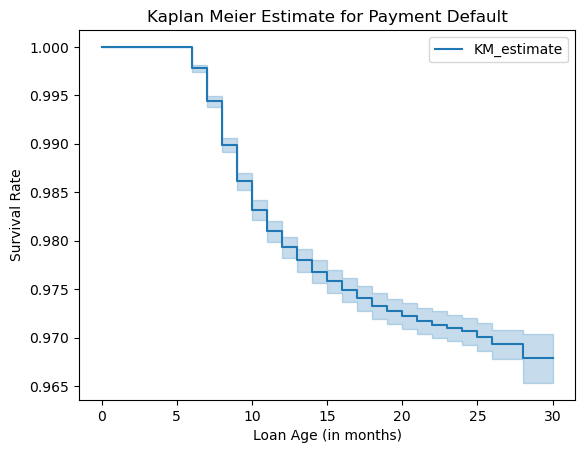

In [64]:
# visulize the curve
kmf.plot_survival_function()
plt.title("Kaplan Meier Estimate for Payment Default")
plt.xlabel("Loan Age (in months)")
plt.ylabel("Survival Rate")

print("The median survival time :",kmf.median_survival_time_)

#### Let's check the loan performance by loan purpose.

In [65]:
df_mod.groupby('PURPOSE')['LOAN_ID'].count()

PURPOSE
C    18718
P    26047
R    28499
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

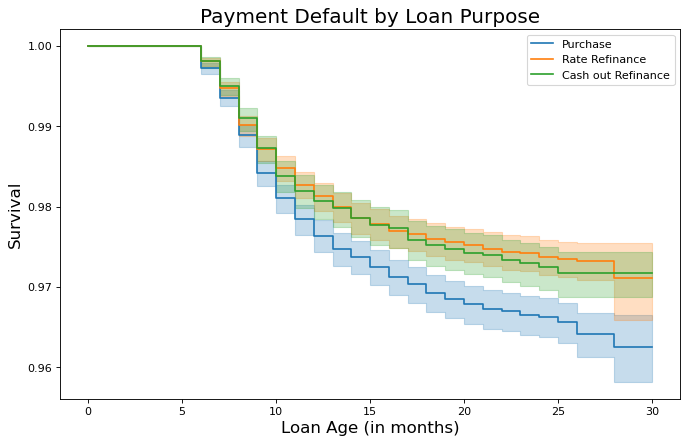

In [67]:
# payment default by loan purpose
loan_age='loan_age_bad'
y='bad'

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)

# This gives bools
purchase=df_mod['PURPOSE'].str.strip()=='P'
rate_refi=df_mod['PURPOSE'].str.strip()=='R'
cashout_refi=df_mod['PURPOSE'].str.strip()=='C'

# fit the model to the three groups of data
kmf.fit(df_mod[loan_age][purchase], event_observed=df_mod[y][purchase], label = 'Purchase')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][rate_refi], event_observed=df_mod[y][rate_refi], label = 'Rate Refinance')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][cashout_refi], event_observed=df_mod[y][cashout_refi], label = 'Cash out Refinance')
kmf.plot(ax = ax)

plt.title("Payment Default by Loan Purpose", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylabel("Survival", fontsize=15)

* Finding 1: Purchase has the highest default rate.  Rate refinance and cash out refinance have similarly lower default rate. 

#### Let's look at the performance of loans by fico scores.

In [68]:
# Payment default by fico tier
def fico_tier(x):
    if x <= 660:
        return '660 or below'
    elif x <= 700:
        return '661-700'
    elif x <= 740:
        return '701-740'
    elif x <=780:
        return '741-780'
    elif x <=800:
        return '781-820'
    else:
        return '820+'
    
df_mod['fico_band']=df_mod['CSCORE_B'].apply(fico_tier)

In [69]:
# check the data
df_mod.groupby('fico_band')['LOAN_ID'].count()

fico_band
660 or below     1918
661-700          6712
701-740         14504
741-780         23721
781-820         15825
820+            10584
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

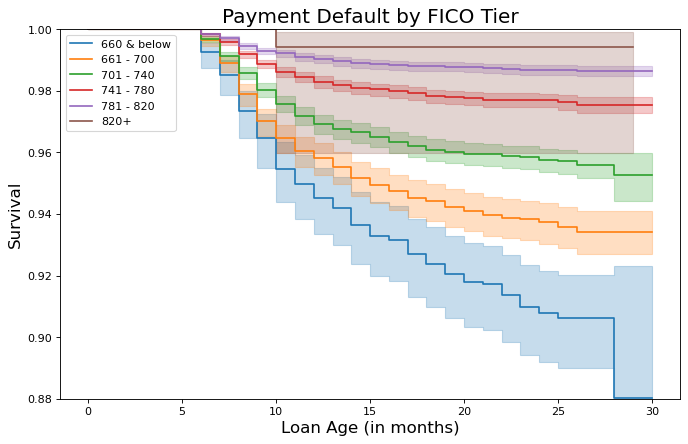

In [70]:
# let's see the performance of different groups of loans with different fico-bands.
fico_660_below=df_mod['CSCORE_B'] <= 660
fico_661_700=(df_mod['CSCORE_B'] > 660) & (df_mod['CSCORE_B'] <= 700)
fico_701_740=(df_mod['CSCORE_B'] > 700) & (df_mod['CSCORE_B'] <= 740)
fico_741_780=(df_mod['CSCORE_B'] > 741) & (df_mod['CSCORE_B'] <= 780)
fico_781_820=(df_mod['CSCORE_B'] > 780) & (df_mod['CSCORE_B'] <= 820)
fico_821_above=df_mod['CSCORE_B'] > 820

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][fico_660_below], event_observed=df_mod[y][fico_660_below], label='660 & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_661_700], event_observed=df_mod[y][fico_661_700], label='661 - 700')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_701_740], event_observed=df_mod[y][fico_701_740], label='701 - 740')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_741_780], event_observed=df_mod[y][fico_741_780], label='741 - 780')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_781_820], event_observed=df_mod[y][fico_781_820], label='781 - 820')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_821_above], event_observed=df_mod[y][fico_821_above], label='820+')
kmf.plot(ax=ax)
plt.title("Payment Default by FICO Tier", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.88, 1)
plt.ylabel("Survival", fontsize=15)

* Finding 2: Risk separation by FICO tier is very obvious.

#### Let's check the performance by property type.

In [71]:
# check property type
df_mod.groupby('PROP')['LOAN_ID'].count()

PROP
CO     7526
CP        9
MH      451
PU    22977
SF    42301
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

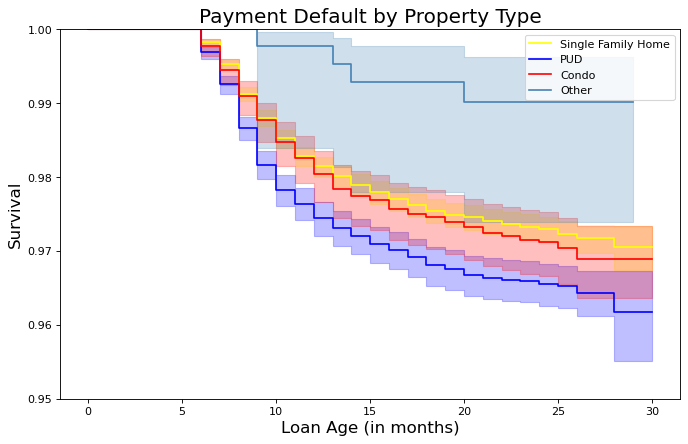

In [72]:
# check the performance of loans with different property type
single_family=df_mod['PROP'].str.strip()=='SF'
pud=df_mod['PROP'].str.strip()=='PU'
condo=df_mod['PROP'].str.strip()=='CO'
other=df_mod['PROP'].str.strip().isin(['CP', 'MH'])

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][single_family], event_observed=df_mod[y][single_family], label='Single Family Home')
kmf.plot(ax=ax, c='yellow')
kmf.fit(df_mod[loan_age][pud], event_observed=df_mod[y][pud], label='PUD')
kmf.plot(ax=ax, c='blue')
kmf.fit(df_mod[loan_age][condo], event_observed=df_mod[y][condo], label='Condo')
kmf.plot(ax=ax, c='red')
kmf.fit(df_mod[loan_age][other], event_observed=df_mod[y][other], label='Other')
kmf.plot(ax=ax, c='steelblue')
plt.title("Payment Default by Property Type", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.95, 1)
plt.ylabel("Survival", fontsize=15)

* Finding 3: PUD has the highest risk.

#### Let's check the loan performance by amount.

In [73]:
# check original loan amount
df_mod['ORIG_UPB'].describe()

count     73264.000000
mean     253702.063769
std      123920.010667
min       10000.000000
25%      156000.000000
50%      236000.000000
75%      335000.000000
max      800000.000000
Name: ORIG_UPB, dtype: float64

In [74]:
# assign amount band to the data
def upb_tier(x):
    if x < 140000: 
        return '140K & below'
    elif x <= 200000: 
        return '140K - 200K'
    elif x <= 300000:
        return '200K - 300K'
    elif x <= 500000:
        return '300K - 500K'
    else:
        return '500K+'
    
df_mod['upb_band']=df_mod['ORIG_UPB'].apply(upb_tier)

In [75]:
# check the data
df_mod.groupby('upb_band')['LOAN_ID'].count()

upb_band
140K & below    14335
140K - 200K     14563
200K - 300K     20794
300K - 500K     21085
500K+            2487
Name: LOAN_ID, dtype: int64

Text(0, 0.5, 'Survival')

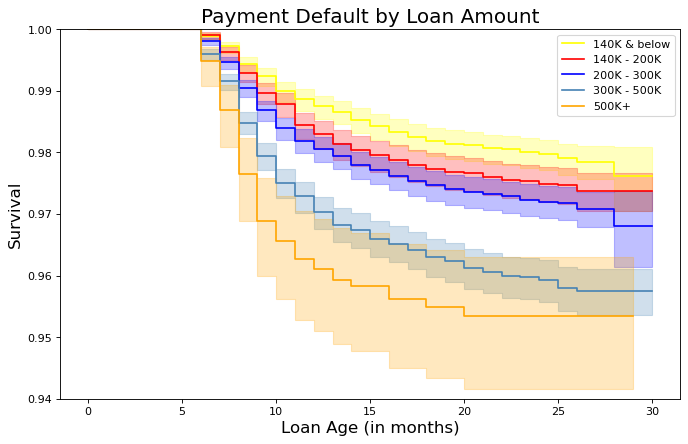

In [76]:
# check the performance of the loan with different amount
upb_140K_below=df_mod['ORIG_UPB'] <= 140000
upb_140K_200K=(df_mod['ORIG_UPB'] > 140000) & (df_mod['ORIG_UPB'] <= 200000)
upb_200K_300K=(df_mod['ORIG_UPB'] > 200000) & (df_mod['ORIG_UPB'] <= 300000)
upb_300K_500K=(df_mod['ORIG_UPB'] > 300000) & (df_mod['ORIG_UPB'] <= 500000)
upb_500K_above=df_mod['ORIG_UPB'] > 500000

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][upb_140K_below], event_observed=df_mod[y][upb_140K_below], label='140K & below')
kmf.plot(ax=ax, c='yellow')
kmf.fit(df_mod[loan_age][upb_140K_200K], event_observed=df_mod[y][upb_140K_200K], label='140K - 200K')
kmf.plot(ax=ax, c='red')
kmf.fit(df_mod[loan_age][upb_200K_300K], event_observed=df_mod[y][upb_200K_300K], label='200K - 300K')
kmf.plot(ax=ax, c='blue')
kmf.fit(df_mod[loan_age][upb_300K_500K], event_observed=df_mod[y][upb_300K_500K], label='300K - 500K')
kmf.plot(ax=ax, c='steelblue')
kmf.fit(df_mod[loan_age][upb_500K_above], event_observed=df_mod[y][upb_500K_above], label='500K+')
kmf.plot(ax=ax, c='orange')
plt.title("Payment Default by Loan Amount", fontsize=18)
plt.xlabel("Loan Age (in months)", fontsize=15)
plt.ylim(0.94, 1)
plt.ylabel("Survival", fontsize=15)

* Finding 4: The higher the original amount is, the higher the risk is.

#### In the analysis above, we need to make multple plots to draw individual Kaplan Meier curves for each group. 
#### We can simply it by using scikit-survial.

Text(0.5, 0, 'Long Age (in months)')

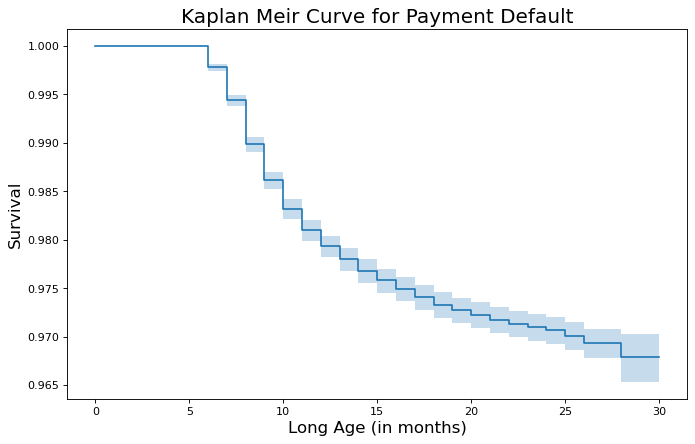

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# need to convert integers (1, 0) to boolean expression (True, False)
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(10, 6), dpi=80)
time, survival_prob,conf_int = kaplan_meier_estimator(df_mod["status"], df_mod[loan_age], conf_type="log-log")
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.title('Kaplan Meir Curve for Payment Default', fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)

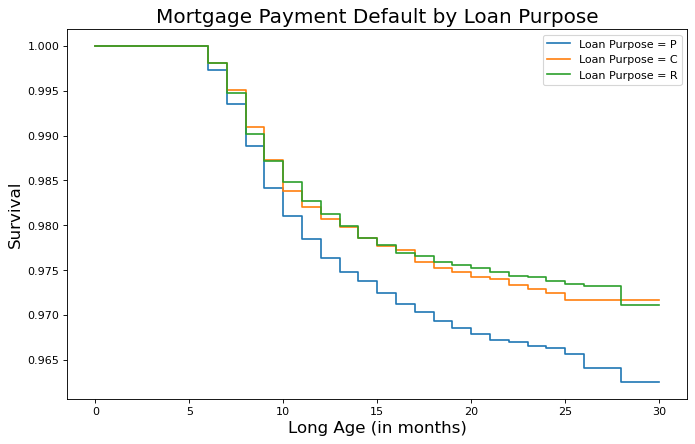

In [79]:
# check the performance of loans with different purposes
figure(figsize=(10, 6), dpi=80)

for treatment_type in ("P", "C", 'R'):
    mask_treat= (df_mod["PURPOSE"] == treatment_type)
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])
 
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Loan Purpose = %s" % treatment_type)

plt.title("Mortgage Payment Default by Loan Purpose", fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

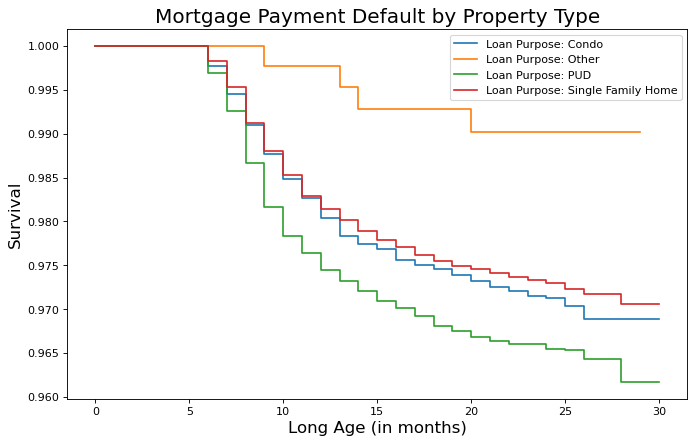

In [80]:
figure(figsize=(10, 6), dpi=80)

df_mod['property_type']=np.where(df_mod['PROP']=='SF', 'Single Family Home', 
                                 np.where(df_mod['PROP']=='PU', 'PUD',
                                          np.where(df_mod['PROP']=='CO', 'Condo', 'Other')))

for treatment_type in (np.unique(df_mod['property_type'])):
    mask_treat=df_mod['property_type']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Loan Purpose: %s" % treatment_type)

plt.title("Mortgage Payment Default by Property Type", fontsize=18)
plt.ylabel("Survival", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

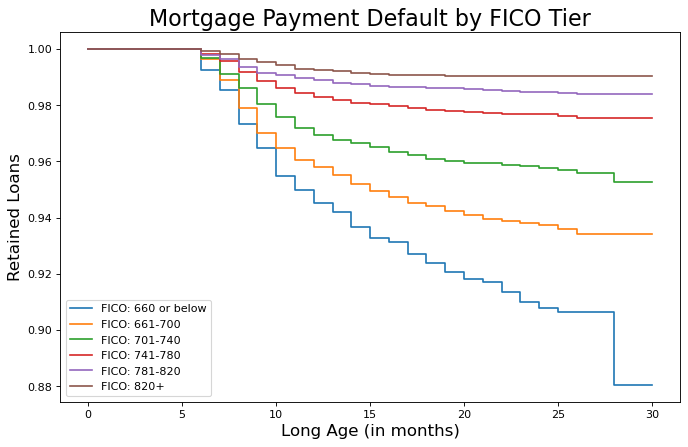

In [81]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['fico_band'])):
    mask_treat=df_mod['fico_band']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="FICO: %s" % treatment_type)

plt.title("Mortgage Payment Default by FICO Tier", fontsize=20)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")

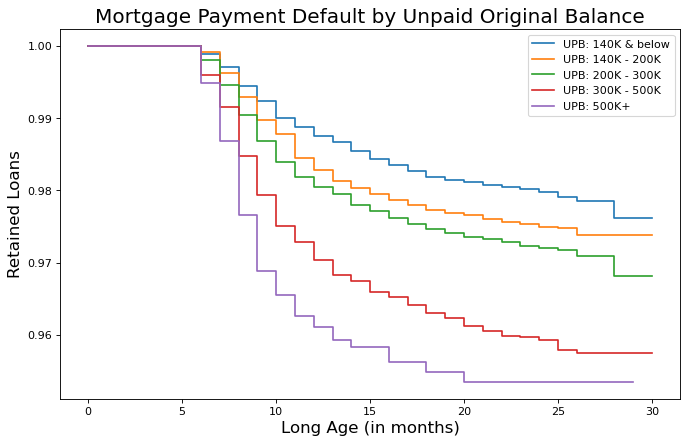

In [82]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['upb_band'])):
    mask_treat=df_mod['upb_band']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="UPB: %s" % treatment_type)

plt.title("Mortgage Payment Default by Unpaid Original Balance", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [87]:
# Now let's look at the original interest rate
# we first cut the data into 5 bins based on quantiles
df_mod['rate_bin1']=pd.qcut(df_mod['ORIG_RATE'], 5)
df_mod.groupby('rate_bin1')['LOAN_ID'].count()

rate_bin1
(2.374, 3.5]     18719
(3.5, 3.75]      20298
(3.75, 3.875]    11117
(3.875, 4.0]      8483
(4.0, 6.5]       14647
Name: LOAN_ID, dtype: int64

In [88]:
# assign loans to different rate bins
df_temp=df_mod.groupby('rate_bin1')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': "loan count"})
df_temp

,rate_bin1,loan count
0,"(2.374, 3.5]",18719
1,"(3.5, 3.75]",20298
2,"(3.75, 3.875]",11117
3,"(3.875, 4.0]",8483
4,"(4.0, 6.5]",14647


<BarContainer object of 5 artists>

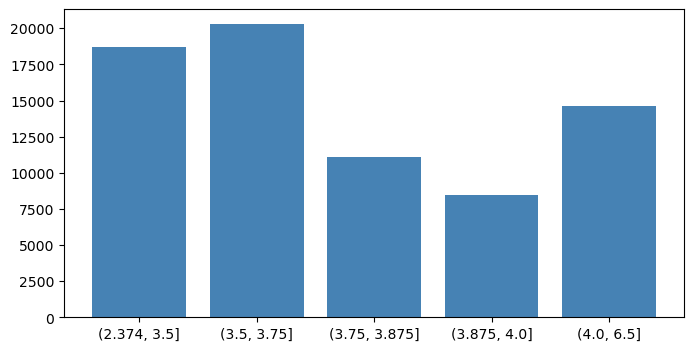

In [89]:
plt.rcParams["figure.figsize"] = (8,4)
plt.bar(df_temp['rate_bin1'].astype(str), df_temp['loan count'], color='steelblue')

In [94]:
# now we try cutting the range evenly into 5 bins
df_mod['rate_bin2']=pd.cut(df_survival['ORIG_RATE'], 5)
df_mod.groupby('rate_bin2')['LOAN_ID'].count()

rate_bin2
(2.371, 3.2]      5247
(3.2, 4.025]     53378
(4.025, 4.85]    12064
(4.85, 5.675]     2437
(5.675, 6.5]       138
Name: LOAN_ID, dtype: int64

<BarContainer object of 5 artists>

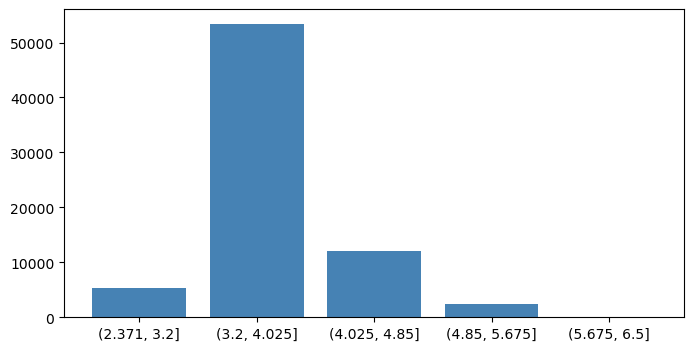

In [95]:
df_temp=df_mod.groupby('rate_bin2')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': "loan count"})

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(df_temp['rate_bin2'].astype(str), df_temp['loan count'], color='steelblue')

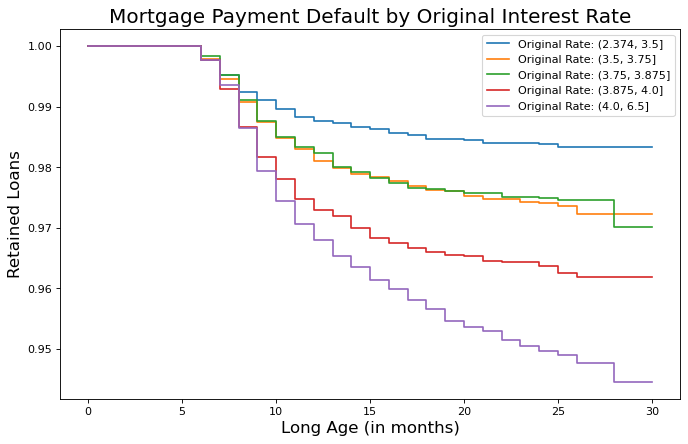

In [96]:
# we first look at the first cut
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['rate_bin1'])):
    mask_treat=df_mod['rate_bin1']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by Original Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")                                      

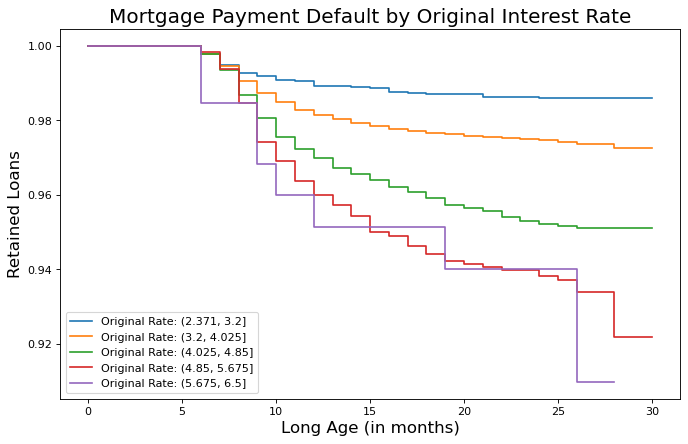

In [97]:
# we then look at the second cut
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['rate_bin2'])):
    mask_treat=df_mod['rate_bin2']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by Original Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")              

* Finding 5: Higher loan interest rate is associated with a higher risk.

#### We look at DTI here.

In [98]:
df_mod['DTI'].describe()

count    73264.000000
mean        34.168459
std          9.566117
min          1.000000
25%         27.000000
50%         35.000000
75%         42.000000
max         50.000000
Name: DTI, dtype: float64

In [99]:
# assign loans to different brackets
def DTI_tier(x):
    if x <= 10: 
        return '10% or below'
    elif x <= 20:
        return '10.01% - 20%'
    elif x <= 30:
        return '20.01% - 30%'
    elif x <= 40: 
        return '30.01% - 40%'
    else:
        return '40%+'

df_mod['DTI_bin']=df_mod['DTI'].apply(DTI_tier)

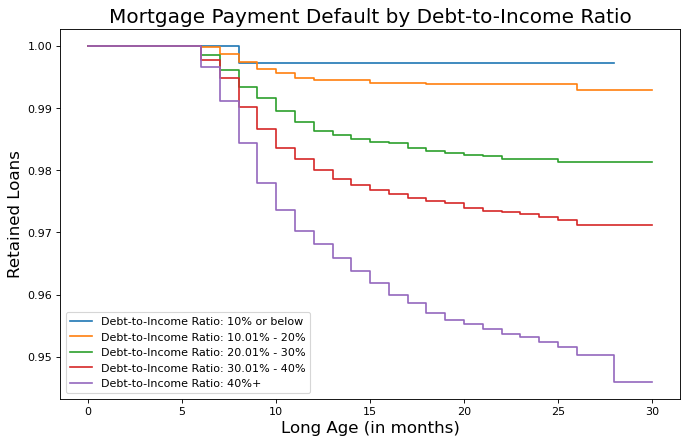

In [102]:
figure(figsize=(10, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI_bin'])):
    mask_treat=df_mod['DTI_bin']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Debt-to-Income Ratio: %s" % treatment_type)

plt.title("Mortgage Payment Default by Debt-to-Income Ratio", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
plt.legend(loc="best")             

* Finding 6: The higher the DTI is, the higher the risk is.

#### If the sample is big enough, we can make more granular segments such as the following: 
* interest rate + loan amount
* interest rate + loan amount + DTI
* etc.

#### Here we look at DTI and FICO segments.

In [103]:
# specify the bins
df_mod['DTI & FICO']='DTI:'+df_mod['DTI_bin'].astype(str)+' / FICO:'+df_mod['fico_band'].astype(str)

# check the data
df_mod.groupby('DTI & FICO')['LOAN_ID'].count()

DTI & FICO
DTI:10% or below / FICO:660 or below       6
DTI:10% or below / FICO:661-700           10
DTI:10% or below / FICO:701-740           36
DTI:10% or below / FICO:741-780          101
DTI:10% or below / FICO:781-820          121
DTI:10% or below / FICO:820+             122
DTI:10.01% - 20% / FICO:660 or below      77
DTI:10.01% - 20% / FICO:661-700          264
DTI:10.01% - 20% / FICO:701-740          718
DTI:10.01% - 20% / FICO:741-780         1751
DTI:10.01% - 20% / FICO:781-820         1991
DTI:10.01% - 20% / FICO:820+            1698
DTI:20.01% - 30% / FICO:660 or below     405
DTI:20.01% - 30% / FICO:661-700         1204
DTI:20.01% - 30% / FICO:701-740         2862
DTI:20.01% - 30% / FICO:741-780         6079
DTI:20.01% - 30% / FICO:781-820         4966
DTI:20.01% - 30% / FICO:820+            3438
DTI:30.01% - 40% / FICO:660 or below     728
DTI:30.01% - 40% / FICO:661-700         2512
DTI:30.01% - 40% / FICO:701-740         5100
DTI:30.01% - 40% / FICO:741-780         8364

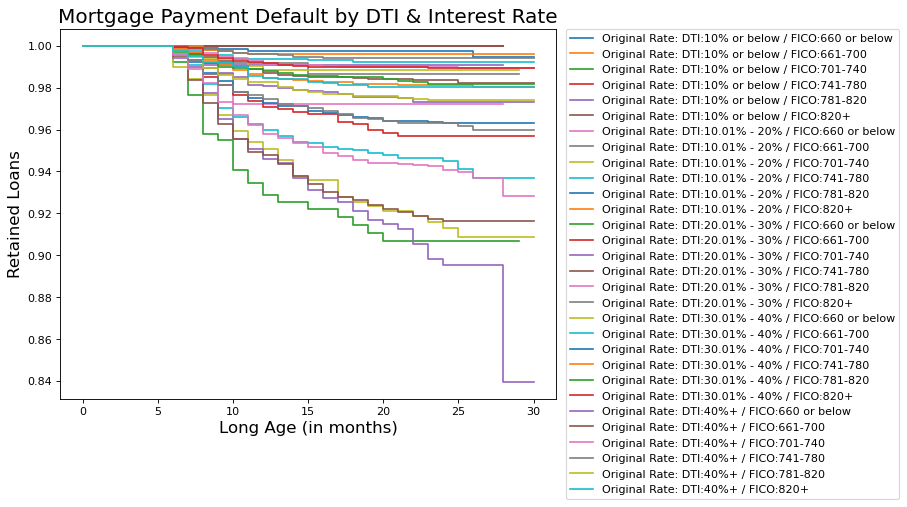

In [104]:
# fit the model to the data
y='bad'
load_age='loan_age_bad'
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(8, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI & FICO'])):
    mask_treat=df_mod['DTI & FICO']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Payment Default by DTI & Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
#plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)     

#### We take out the survival rate in each group.

In [105]:
group_list=np.unique(df_mod['DTI & FICO'])

kmf_curve_temp=[]
for item in group_list:
    df_temp= copy.deepcopy(df_mod[df_mod['DTI & FICO']==item])
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion.
    kmf = KaplanMeierFitter()
    df_mod_estimate=kmf.fit(df_temp['loan_age_bad'], event_observed=df_temp['bad'])
    
    # fetch the estimated surviving rate
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})

    # add shell of loan age in case some timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_bad'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
    kmf_curve_bad=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_est_surviving_bad'})

In [110]:
kmf_curve_bad

,loan_age,KM_est_surviving_bad,group_name
0,0.0,1.000000,DTI:10% or below / FICO:660 or below
1,1.0,1.000000,DTI:10% or below / FICO:660 or below
2,2.0,1.000000,DTI:10% or below / FICO:660 or below
3,3.0,1.000000,DTI:10% or below / FICO:660 or below
4,4.0,1.000000,DTI:10% or below / FICO:660 or below
...,...,...,...
26,26.0,0.980449,DTI:40%+ / FICO:820+
27,27.0,0.980449,DTI:40%+ / FICO:820+
28,28.0,0.980449,DTI:40%+ / FICO:820+
29,29.0,0.980449,DTI:40%+ / FICO:820+


### Part 3: Kaplan Meier Curve for Voluntary Prepayment
* We will use scikit-survival only here.

In [111]:
# specify the time and event
loan_age='loan_age_prepaid'
y='prepaid'

Text(0, 0.5, 'Survival')

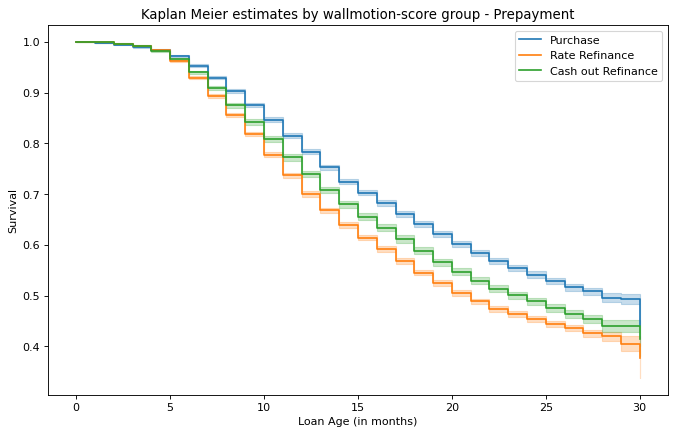

In [112]:
# look at loan purpose
figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
purchase=df_mod['PURPOSE'].str.strip()=='P'
rate_refi=df_mod['PURPOSE'].str.strip()=='R'
cashout_refi=df_mod['PURPOSE'].str.strip()=='C'

kmf.fit(df_mod[loan_age][purchase], event_observed=df_mod[y][purchase], label = 'Purchase')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][rate_refi], event_observed=df_mod[y][rate_refi], label = 'Rate Refinance')
kmf.plot(ax = ax)
kmf.fit(df_mod[loan_age][cashout_refi], event_observed=df_mod[y][cashout_refi], label = 'Cash out Refinance')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by loan purpose group - Prepayment")
plt.xlabel("Loan Age (in months)")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

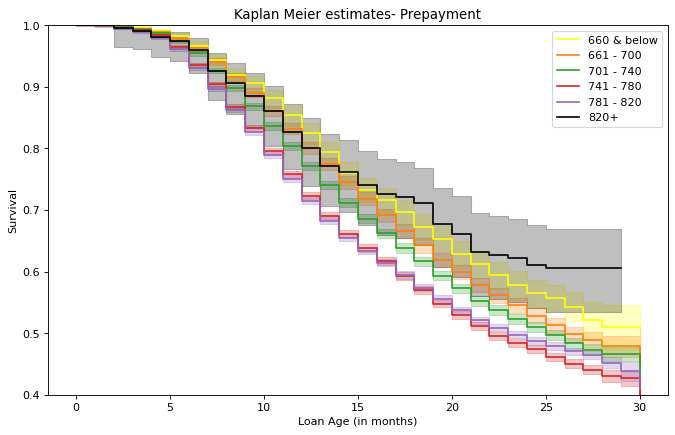

In [118]:
# fico band
fico_660_below=df_mod['CSCORE_B'] <= 660
fico_661_700=(df_mod['CSCORE_B'] > 660) & (df_mod['CSCORE_B'] <= 700)
fico_701_740=(df_mod['CSCORE_B'] > 700) & (df_mod['CSCORE_B'] <= 740)
fico_741_780=(df_mod['CSCORE_B'] > 741) & (df_mod['CSCORE_B'] <= 780)
fico_781_820=(df_mod['CSCORE_B'] > 780) & (df_mod['CSCORE_B'] <= 820)
fico_821_above=df_mod['CSCORE_B'] > 820

figure(figsize=(10, 6), dpi=80)                                                                                    
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][fico_660_below], event_observed=df_mod[y][fico_660_below], label='660 & below')
kmf.plot(ax=ax, c='yellow')
kmf.fit(df_mod[loan_age][fico_661_700], event_observed=df_mod[y][fico_661_700], label='661 - 700')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_701_740], event_observed=df_mod[y][fico_701_740], label='701 - 740')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_741_780], event_observed=df_mod[y][fico_741_780], label='741 - 780')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_781_820], event_observed=df_mod[y][fico_781_820], label='781 - 820')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][fico_821_above], event_observed=df_mod[y][fico_821_above], label='820+')
kmf.plot(ax=ax, c='k')
plt.title("Kaplan Meier estimates- Prepayment")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.40, 1)                                        
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

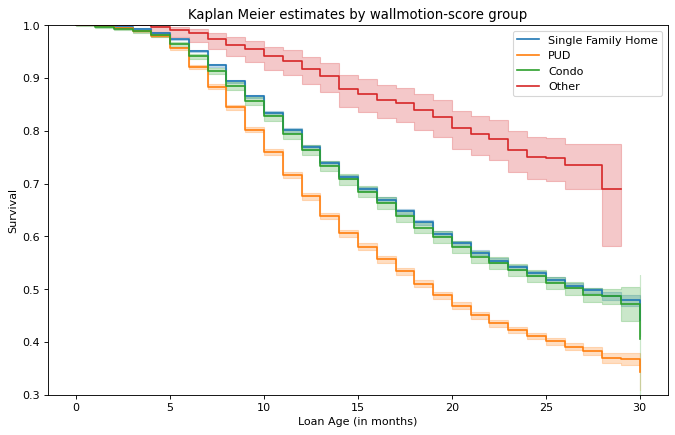

In [119]:
# property type
single_family=df_mod['PROP'].str.strip()=='SF'
pud=df_mod['PROP'].str.strip()=='PU'
condo=df_mod['PROP'].str.strip()=='CO'
other=df_mod['PROP'].str.strip().isin(['CP', 'MH'])

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][single_family], event_observed=df_mod[y][single_family], label='Single Family Home')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][pud], event_observed=df_mod[y][pud], label='PUD')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][condo], event_observed=df_mod[y][condo], label='Condo')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][other], event_observed=df_mod[y][other], label='Other')
kmf.plot(ax=ax)
plt.title("Kaplan Meier estimates by wallmotion-score group")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.3, 1)
plt.ylabel("Survival")

In [120]:
# original unpaid amount
df_mod.groupby('PROP')['ORIG_UPB'].describe().reset_index()

,PROP,count,mean,std,min,25%,50%,75%,max
0,CO,7526.0,225412.171140,104960.009119,27000.0,146000.0,209000.0,288000.0,727000.0
1,CP,9.0,78222.222222,55950.374837,28000.0,42000.0,55000.0,95000.0,200000.0
2,MH,451.0,131017.738359,75118.748334,31000.0,79500.0,110000.0,159500.0,510000.0
3,PU,22977.0,313925.316621,117080.278078,19000.0,228000.0,304000.0,394000.0,766000.0
4,SF,42301.0,227368.643767,118985.915229,10000.0,136000.0,203000.0,298000.0,800000.0


Text(0, 0.5, 'Survival')

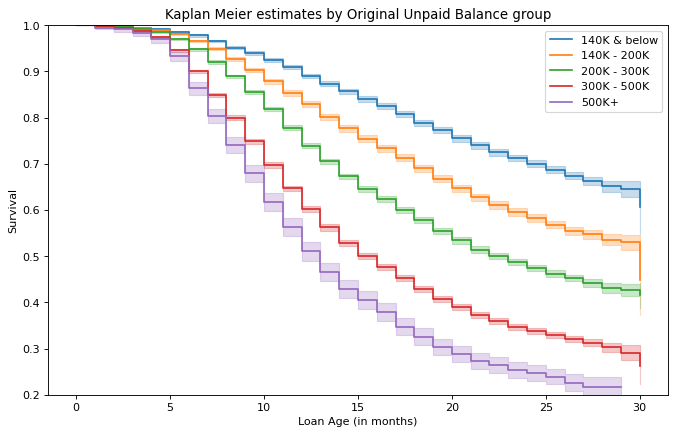

In [122]:
upb_140K_200K=(df_mod['ORIG_UPB'] > 140000) & (df_mod['ORIG_UPB'] <= 200000)
upb_200K_300K=(df_mod['ORIG_UPB'] > 200000) & (df_mod['ORIG_UPB'] <= 300000)
upb_300K_500K=(df_mod['ORIG_UPB'] > 300000) & (df_mod['ORIG_UPB'] <= 500000)
upb_500K_above=df_mod['ORIG_UPB'] > 500000

figure(figsize=(10, 6), dpi=80)
ax = plt.subplot(111)
kmf.fit(df_mod[loan_age][upb_140K_below], event_observed=df_mod[y][upb_140K_below], label='140K & below')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_140K_200K], event_observed=df_mod[y][upb_140K_200K], label='140K - 200K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_200K_300K], event_observed=df_mod[y][upb_200K_300K], label='200K - 300K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_300K_500K], event_observed=df_mod[y][upb_300K_500K], label='300K - 500K')
kmf.plot(ax=ax)
kmf.fit(df_mod[loan_age][upb_500K_above], event_observed=df_mod[y][upb_500K_above], label='500K+')
kmf.plot(ax=ax)                                                                                                        
plt.title("Kaplan Meier estimates by Original Unpaid Balance group")
plt.xlabel("Loan Age (in months)")
plt.ylim(0.2, 1)
plt.ylabel("Survival")

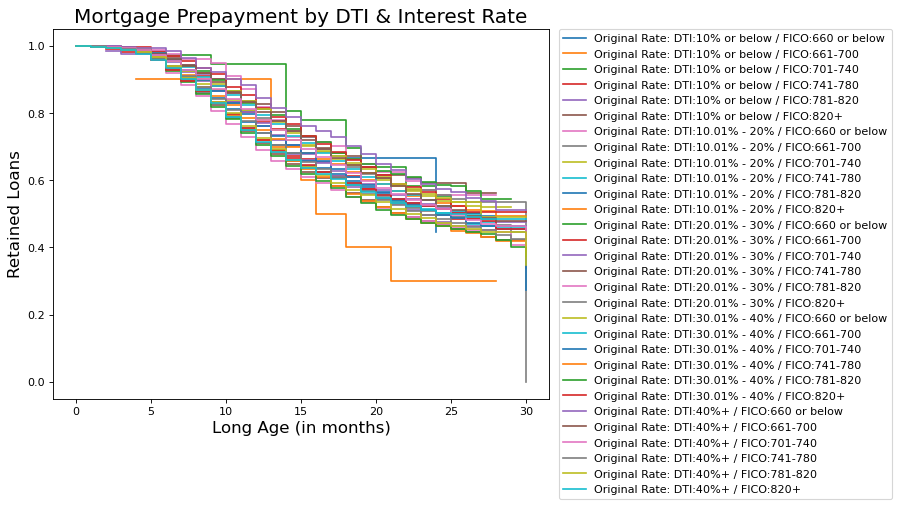

In [125]:
# need to convert integers (1, 0) to boolean expression (True, False)
df_mod['status']=df_mod[y].map({1: True, 0: False})

figure(figsize=(8, 6), dpi=80)

for treatment_type in (np.unique(df_mod['DTI & FICO'])):
    mask_treat=df_mod['DTI & FICO']==treatment_type
    time_treatment, survival_prob_treatment=kaplan_meier_estimator(
        df_mod["status"][mask_treat],
        df_mod[loan_age][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Original Rate: %s" % treatment_type)

plt.title("Mortgage Prepayment by DTI & Interest Rate", fontsize=18)
plt.ylabel("Retained Loans", fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
plt.xlabel("Long Age (in months)", fontsize=15)
#plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)        
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)     

In [144]:
# Let's fetch the KM estimates.
group_list=np.unique(df_mod['DTI & FICO'])

kmf_curve_temp=[]
for item in group_list:
    df_temp=df_mod[df_mod['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_mod_estimate=kmf.fit(df_temp['loan_age_prepaid'], 
                                 event_observed=df_temp['prepaid'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})

    # add shell of loan age in case some timeline might be missing for KM curve. 
    # Note that here the last time point is the maximum of the loan age.
    loan_age_shell=np.arange(0, max(df_temp['loan_age_prepaid'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=loan_age_shell.merge(kmf_curve, on='loan_age', how='left')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
    kmf_curve_prepay=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_est_surviving_prepay'})

In [145]:
kmf_curve_prepay

,loan_age,KM_est_surviving_prepay,group_name
0,0,1.000000,DTI:10% or below / FICO:660 or below
1,1,0.666667,DTI:10% or below / FICO:660 or below
2,2,0.666667,DTI:10% or below / FICO:660 or below
3,3,0.666667,DTI:10% or below / FICO:660 or below
4,4,0.666667,DTI:10% or below / FICO:660 or below
...,...,...,...
26,26,0.490946,DTI:40%+ / FICO:820+
27,27,0.483508,DTI:40%+ / FICO:820+
28,28,0.483508,DTI:40%+ / FICO:820+
29,29,0.483508,DTI:40%+ / FICO:820+


### Part 4: Combine Kaplan Meier estimates for payment default and prepayment

In [146]:
# We use the results on the training set as estimated surviving function.
survival_estimate=pd.merge(kmf_curve_bad, kmf_curve_prepay, on=['group_name', 'loan_age'], how='inner')
survival_estimate=survival_estimate[['group_name', 'loan_age', 'KM_est_surviving_bad', 'KM_est_surviving_prepay']]

# Calculate the estimated cumulated 'death' rate for 'bad' loans.
survival_estimate['est_cumu_bad']=1-survival_estimate['KM_est_surviving_bad']

# Calculate the estimated cumulated 'death' rate for prepaid loans.
survival_estimate['est_cumu_prepay']=1-survival_estimate['KM_est_surviving_prepay']

In [147]:
# check the data
survival_estimate

,group_name,loan_age,KM_est_surviving_bad,KM_est_surviving_prepay,est_cumu_bad,est_cumu_prepay
0,DTI:10% or below / FICO:660 or below,0.0,1.000000,1.000000,0.000000,0.000000
1,DTI:10% or below / FICO:660 or below,1.0,1.000000,0.666667,0.000000,0.333333
2,DTI:10% or below / FICO:660 or below,2.0,1.000000,0.666667,0.000000,0.333333
3,DTI:10% or below / FICO:660 or below,3.0,1.000000,0.666667,0.000000,0.333333
4,DTI:10% or below / FICO:660 or below,4.0,1.000000,0.666667,0.000000,0.333333
...,...,...,...,...,...,...
903,DTI:40%+ / FICO:820+,26.0,0.980449,0.490946,0.019551,0.509054
904,DTI:40%+ / FICO:820+,27.0,0.980449,0.483508,0.019551,0.516492
905,DTI:40%+ / FICO:820+,28.0,0.980449,0.483508,0.019551,0.516492
906,DTI:40%+ / FICO:820+,29.0,0.980449,0.483508,0.019551,0.516492


### Part 4: Validate on the validation model

In [152]:
# assign observations to different FICO band.
def fico_tier(x):
    if x <= 660:
        return '660 or below'
    elif x <= 700:
        return '661-700'
    elif x <= 740:
        return '701-740'
    elif x <=780:
        return '741-780'
    elif x <=800:
        return '781-820'
    else:
        return '820+'
    
df_val['fico_band']=df_val['CSCORE_B'].apply(fico_tier)

# assign observations to different DTI bands
def DTI_tier(x):
    if x <= 10: 
        return '10% or below'
    elif x <= 20:
        return '10.01%-20%'
    elif x <= 30:
        return '20.01%-30%'
    elif x <= 40: 
        return '30.01%-40%'
    else:
        return '40%+'

df_val['DTI_bin']=df_val['DTI'].apply(DTI_tier)

In [153]:
# create te 'DTI&FICO' group for validation set
df_val['DTI & FICO']='DTI:'+df_val['DTI_bin'].astype(str)+' / FICO:'+df_val['fico_band'].astype(str)

In [154]:
# fit the K-M model to the validation set
group_list=np.unique(df_val['DTI & FICO'])

kmf_curve_temp=[]
for item in group_list:
    df_temp=df_val[df_val['DTI & FICO']==item]
    
    # We must reset kmf so that it will not inherit computation from above to cause confusion
    kmf = KaplanMeierFitter()
    df_val_estimate=kmf.fit(df_temp['loan_age_prepaid'], event_observed=df_temp['prepaid'])
    kmf_curve=kmf.survival_function_.reset_index().rename(columns={'timeline': 'loan_age'})
    
    # add shell of loan age in case soe timeline might be missing for KM curve
    loan_age_shell=np.arange(0, max(df_temp['loan_age_prepaid'].astype(int))+1, 1)
    loan_age_shell=pd.DataFrame(loan_age_shell).rename(columns={0: 'loan_age'})
    kmf_curve=pd.merge(kmf_curve, loan_age_shell, on='loan_age', how='outer')
    kmf_curve=kmf_curve.sort_values(by='loan_age').reset_index().drop('index', axis=1)
    # for those months (loan age) with missing KM_estimate, it means the survival rate the same as the previous month.
    # Therefore, we fill with the value backwards.
    kmf_curve['KM_estimate']=kmf_curve['KM_estimate'].bfill()
    kmf_curve['group_name']=item
    kmf_curve_temp.append(kmf_curve)
    
kmf_curve_prepay_val=pd.concat(kmf_curve_temp, axis=0).rename(columns={'KM_estimate': 'KM_act_surviving_prepay'})
kmf_curve_prepay_val

,loan_age,KM_act_surviving_prepay,group_name
0,0.0,1.000000,DTI:10% or below / FICO:660 or below
1,1.0,1.000000,DTI:10% or below / FICO:660 or below
2,2.0,1.000000,DTI:10% or below / FICO:660 or below
3,3.0,1.000000,DTI:10% or below / FICO:660 or below
4,4.0,1.000000,DTI:10% or below / FICO:660 or below
...,...,...,...
26,26.0,0.520038,DTI:40%+ / FICO:820+
27,27.0,0.520038,DTI:40%+ / FICO:820+
28,28.0,0.487535,DTI:40%+ / FICO:820+
29,29.0,0.487535,DTI:40%+ / FICO:820+


In [155]:
kmf_curve_prepay_val['group_name'].unique()

array(['DTI:10% or below / FICO:660 or below',
       'DTI:10% or below / FICO:661-700',
       'DTI:10% or below / FICO:701-740',
       'DTI:10% or below / FICO:741-780',
       'DTI:10% or below / FICO:781-820', 'DTI:10% or below / FICO:820+',
       'DTI:10.01%-20% / FICO:660 or below',
       'DTI:10.01%-20% / FICO:661-700', 'DTI:10.01%-20% / FICO:701-740',
       'DTI:10.01%-20% / FICO:741-780', 'DTI:10.01%-20% / FICO:781-820',
       'DTI:10.01%-20% / FICO:820+', 'DTI:20.01%-30% / FICO:660 or below',
       'DTI:20.01%-30% / FICO:661-700', 'DTI:20.01%-30% / FICO:701-740',
       'DTI:20.01%-30% / FICO:741-780', 'DTI:20.01%-30% / FICO:781-820',
       'DTI:20.01%-30% / FICO:820+', 'DTI:30.01%-40% / FICO:660 or below',
       'DTI:30.01%-40% / FICO:661-700', 'DTI:30.01%-40% / FICO:701-740',
       'DTI:30.01%-40% / FICO:741-780', 'DTI:30.01%-40% / FICO:781-820',
       'DTI:30.01%-40% / FICO:820+', 'DTI:40%+ / FICO:660 or below',
       'DTI:40%+ / FICO:661-700', 'DTI:40%+ / FICO:

In [157]:
# the actual survival rates are the estimated results using the validation sample
survival_actual=pd.merge(kmf_curve_bad_val, kmf_curve_prepay_val, on=['group_name', 'loan_age'], how='inner')
survival_actual=survival_actual[['group_name', 'loan_age', 'KM_act_surviving_bad', 'KM_act_surviving_prepay']]
survival_actual['act_cumu_bad']=1-survival_actual['KM_act_surviving_bad']
survival_actual['act_cumu_prepay']=1-survival_actual['KM_act_surviving_prepay']

In [158]:
# compare the estimated and actual survival rates. we merge them together
merge_two=pd.merge(survival_estimate, survival_actual, on=['loan_age', 'group_name'], how='inner')

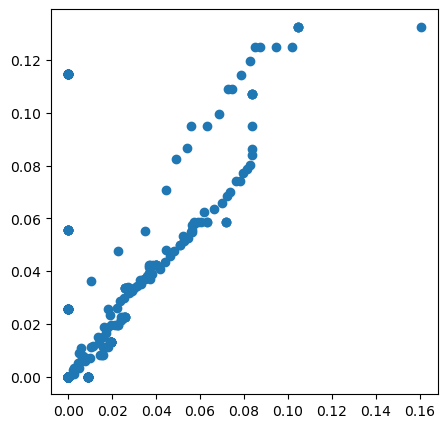

In [162]:
# plt the relationship between the estimated and the actual acumulated 'death' rate of the 'bad' loans
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(merge_two['est_cumu_bad'], merge_two['act_cumu_bad'])

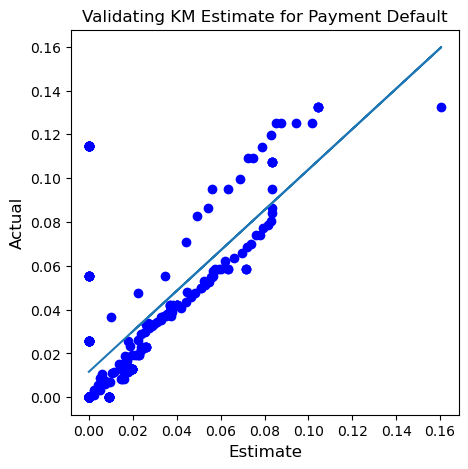

                            OLS Regression Results                            
Dep. Variable:           act_cumu_bad   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     273.1
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.09e-45
Time:                        15:06:58   Log-Likelihood:                 747.70
No. Observations:                 350   AIC:                            -1491.
Df Residuals:                     348   BIC:                            -1484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0116      0.002      6.328   

In [165]:
# let's add a linear regression line onto it 
x= merge_two['est_cumu_bad']
y= merge_two['act_cumu_bad']

plt.scatter(x, y, color='b')
plt.xlabel('Estimate', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title("Validating KM Estimate for Payment Default", fontsize=12)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

In [166]:
# let's check and see if the estimation is legit
df_mod.groupby('DTI & FICO')['LOAN_ID'].count()

DTI & FICO
DTI:10% or below / FICO:660 or below       6
DTI:10% or below / FICO:661-700           10
DTI:10% or below / FICO:701-740           36
DTI:10% or below / FICO:741-780          101
DTI:10% or below / FICO:781-820          121
DTI:10% or below / FICO:820+             122
DTI:10.01% - 20% / FICO:660 or below      77
DTI:10.01% - 20% / FICO:661-700          264
DTI:10.01% - 20% / FICO:701-740          718
DTI:10.01% - 20% / FICO:741-780         1751
DTI:10.01% - 20% / FICO:781-820         1991
DTI:10.01% - 20% / FICO:820+            1698
DTI:20.01% - 30% / FICO:660 or below     405
DTI:20.01% - 30% / FICO:661-700         1204
DTI:20.01% - 30% / FICO:701-740         2862
DTI:20.01% - 30% / FICO:741-780         6079
DTI:20.01% - 30% / FICO:781-820         4966
DTI:20.01% - 30% / FICO:820+            3438
DTI:30.01% - 40% / FICO:660 or below     728
DTI:30.01% - 40% / FICO:661-700         2512
DTI:30.01% - 40% / FICO:701-740         5100
DTI:30.01% - 40% / FICO:741-780         8364

In [167]:
# we calculate how many observations are there in each group
df_count=df_mod.groupby('DTI & FICO')['LOAN_ID'].count().reset_index().rename(columns={'LOAN_ID': 'loan_cnt', 
                                                                                       'DTI & FICO': 'group_name'})

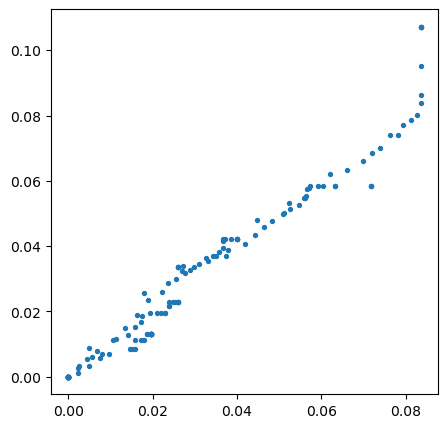

In [173]:
# we add the information of how many observations are in each group into the data
merge_two2=pd.merge(df_count, merge_two, on='group_name', how='inner')

# keep those groups with observations more than 1000 since the estimation is more robust
for_graph=merge_two[merge_two2['loan_cnt'] > 1000]

# visualize it 
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(for_graph['est_cumu_bad'], for_graph['act_cumu_bad'], s=8)

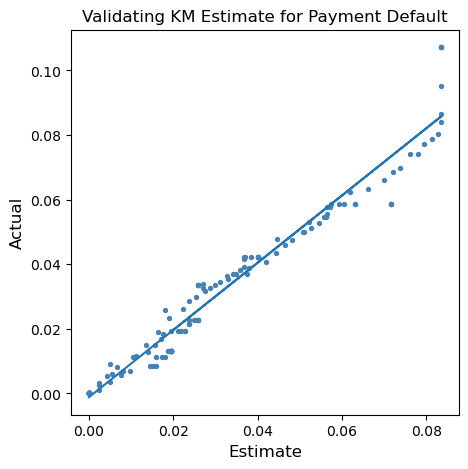

                            OLS Regression Results                            
Dep. Variable:           act_cumu_bad   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     3565.
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          6.57e-108
Time:                        15:16:39   Log-Likelihood:                 589.23
No. Observations:                 155   AIC:                            -1174.
Df Residuals:                     153   BIC:                            -1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0012      0.001     -1.769   

In [176]:
x=for_graph['est_cumu_bad']
y=for_graph['act_cumu_bad']

plt.scatter(x, y, color='steelblue', s=8)
plt.xlabel('Estimate', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title("Validating KM Estimate for Payment Default", fontsize=12)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

#### Now we apply the same process to the prepayment data.

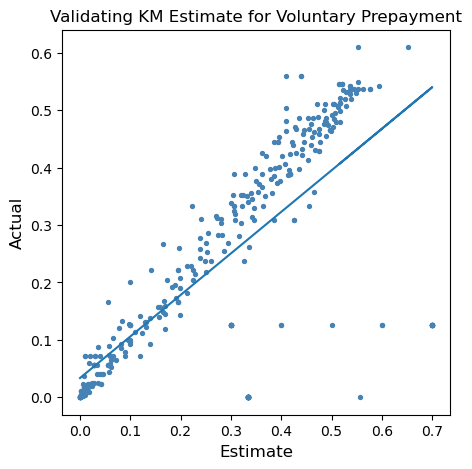

                            OLS Regression Results                            
Dep. Variable:        act_cumu_prepay   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     421.7
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           5.91e-62
Time:                        15:18:21   Log-Likelihood:                 220.60
No. Observations:                 350   AIC:                            -437.2
Df Residuals:                     348   BIC:                            -429.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0334      0.012     

In [179]:
x=merge_two['est_cumu_prepay']
y= merge_two['act_cumu_prepay']

plt.scatter(x, y, color='steelblue', s=8)
plt.xlabel('Estimate', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title("Validating KM Estimate for Voluntary Prepayment", fontsize=12)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

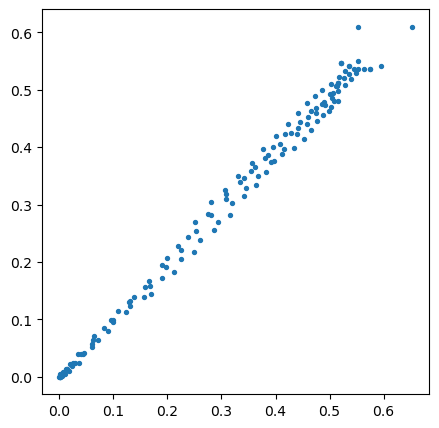

In [180]:
# here we also keep those groups with more than 1000 observations 
merge_two2=pd.merge(df_count, merge_two, on='group_name', how='inner')
for_graph=merge_two[merge_two2['loan_cnt'] > 1000]

plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(for_graph['est_cumu_prepay'], for_graph['act_cumu_prepay'], s=8)

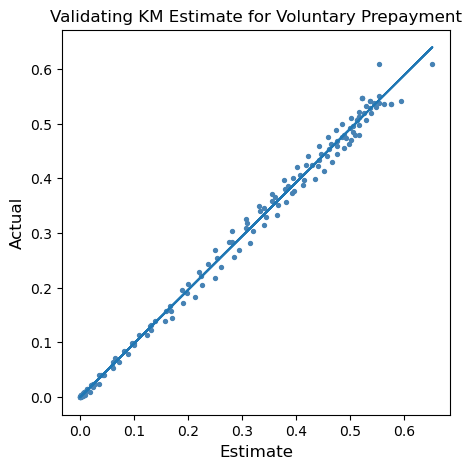

                            OLS Regression Results                            
Dep. Variable:        act_cumu_prepay   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.368e+04
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          1.20e-169
Time:                        15:19:40   Log-Likelihood:                 423.88
No. Observations:                 155   AIC:                            -843.8
Df Residuals:                     153   BIC:                            -837.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0004      0.002     

In [181]:
x=for_graph['est_cumu_prepay']
y=for_graph['act_cumu_prepay']

plt.scatter(x, y, color='steelblue', s=8)
plt.xlabel('Estimate', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title("Validating KM Estimate for Voluntary Prepayment", fontsize=12)

# add a regression line to show the relationship
m, b=np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()


# Regression analysis
import statsmodels.api as sm

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

### Part 5: Cox Proportional Hazards Model

#### We first check the basics of the data.

In [224]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73264 entries, 1 to 104922
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LOAN_ID           73264 non-null  int64   
 1   loan_age_bad      73264 non-null  float64 
 2   bad               73264 non-null  int64   
 3   loan_age_prepaid  73264 non-null  float64 
 4   prepaid           73264 non-null  int64   
 5   ORIG_RATE         73264 non-null  float64 
 6   CURR_RATE         73264 non-null  float64 
 7   ORIG_UPB          73264 non-null  float64 
 8   ORIG_TERM         73264 non-null  int64   
 9   OLTV              73264 non-null  int64   
 10  OCLTV             73264 non-null  int64   
 11  DTI               73264 non-null  float64 
 12  CSCORE_B          73264 non-null  float64 
 13  PURPOSE           73264 non-null  object  
 14  PROP              73264 non-null  object  
 15  STATE             73264 non-null  object  
 16  random            732

In [225]:
df_bad['bad'].mean()

0.02353131790629408

In [226]:
# fit the cox model to the data
from lifelines import CoxPHFitter

df_ph= copy.deepcopy(df_mod[['loan_age_bad', 'bad', 'CSCORE_B', 'OLTV', 'DTI', 'ORIG_RATE', 'ORIG_UPB']])

# replace the loan_age to be 1 if they are smaller than 1
df_mod['loan_age_bad']=np.where(df_ph['loan_age_bad'] <= 0, 1, df_ph['loan_age_bad'])

cph = CoxPHFitter()
cph.fit(df_ph, duration_col='loan_age_bad', event_col='bad')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 73264 total observations, 71561 right-censored observations>
             duration col = 'loan_age_bad'
                event col = 'bad'
      baseline estimation = breslow
   number of observations = 73264
number of events observed = 1703
   partial log-likelihood = -17986.74
         time fit was run = 2023-08-20 23:04:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CSCORE_B   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
OLTV        0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
DTI         0.04       1.04       0.00             0.04             0.05                 1.04                 1.05
ORIG_RATE   0.31       1.37       0.05             0.21             0.41                 1.23                 1.51
ORIG_UPB    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

            cmp to      z      p   -log2(p)
covariate                                  
CSCORE_B      0.00 -20.14 <0.005     297.30
OLTV          0.00   9.92 <0.005      74.62
DTI           0.00  13.62 <0.005     137.95
ORIG_RATE     0.00   5.96 <0.005      28.53
ORIG_UPB      0.00  13.86 <0.005     142.63
---
Concordance = 0.73
Partial AIC = 35983.47
log-likelihood ratio test = 1271.17 on 5 df
-log2(p) of ll-ratio test = 903.40

<AxesSubplot: xlabel='log(HR) (95% CI)'>

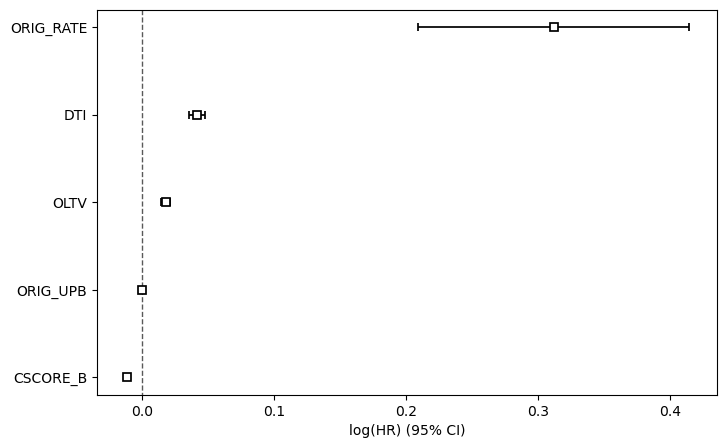

In [227]:
# visulize the parameter
plt.subplots(figsize = (8,5))
cph.plot()

<AxesSubplot: >

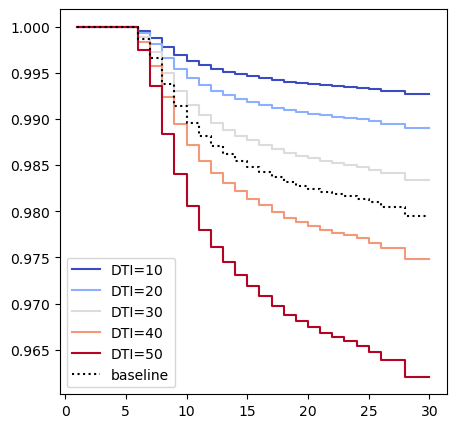

In [228]:
# Produces a plot comparing the baseline curve of the model versus what happens when a covariate(s) is varied 
# over values in a group. This is useful to compare subjects’ survival as we vary covariate(s), 
# all else being held equal.
# The baseline curve is equal to the predicted curve at all average values (median for ordinal, 
# and mode for categorical) in the original dataset. This same logic is applied to the stratified datasets 
# if strata was used in fitting.
cph.plot_partial_effects_on_outcome(covariates = 'DTI', values = [10, 20, 30, 40, 50], cmap = 'coolwarm')

<AxesSubplot: >

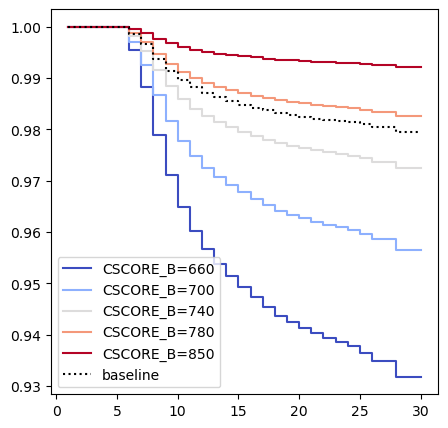

In [229]:
# check the effect of credit score
cph.plot_partial_effects_on_outcome(covariates = 'CSCORE_B', values = [660, 700, 740, 780, 850], cmap = 'coolwarm')

In [230]:
# check the assumptions
cph.check_assumptions(df_ph, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 73264 total observations, 71561 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
CSCORE_B  km              0.16   0.69      0.54
          rank            0.21   0.65      0.63
DTI       km              1.49   0.22      2.17
          rank            1.37   0.24      2.05
OLTV      km              1.38   0.24      2.06
          rank            1.91   0.17      2.58
ORIG_RATE km             18.02 <0.005     15.48
          rank           12.88 <0.005     11.55
ORIG_UPB  km             17.45 <0.005     15.05
          rank           20.24 <0.005     17.16



1. Variable 'ORIG_RATE' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'ORIG_RATE' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ORIG_RATE' using pd.cut, and then specify it in
`strata=['ORIG_RATE', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'ORIG_UPB' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'ORIG_UPB' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

[]

In [232]:
df_ph2 = copy.deepcopy(df_ph)

def upb_tierCox(x):
    if x < 140000: 
        return int(1)
    elif x <= 200000: 
        return int(2)
    elif x <= 300000:
        return int(3)
    elif x <= 500000:
        return int(4)
    else:
        return int(5)
    
df_ph2['upb_band']=df_ph2['ORIG_UPB'].apply(upb_tierCox)


def rate_tierCox(x):
    if x < 3.5: 
        return int(1)
    elif x <= 3.75: 
        return int(2)
    elif x <= 3.875:
        return int(3)
    elif x <= 4.0:
        return int(4)
    else:
        return int(5)
    
df_ph2['rate_band']=df_ph2['ORIG_RATE'].apply(rate_tierCox)

df_ph2 = copy.deepcopy(df_ph2[['loan_age_bad', 'bad', 'CSCORE_B', 'OLTV', 'DTI','upb_band', 'rate_band']])

In [233]:
cph2 = CoxPHFitter()
cph2.fit(df_ph2, duration_col='loan_age_bad', event_col='bad', strata=['upb_band','rate_band'])
cph2.print_summary() 

<lifelines.CoxPHFitter: fitted with 73264 total observations, 71561 right-censored observations>
             duration col = 'loan_age_bad'
                event col = 'bad'
                   strata = ['upb_band', 'rate_band']
      baseline estimation = breslow
   number of observations = 73264
number of events observed = 1703
   partial log-likelihood = -13006.60
         time fit was run = 2023-08-20 23:04:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CSCORE_B   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
OLTV        0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
DTI         0.04       1.04       0.00             0.04             0.05                 1.04                 1.05

            cmp to      z      p   -log2(p)
covariate                                  
CSCORE_B      0.00 -20.30 <0.005     301.83
OLTV          0.00   9.53 <0.005      69.05
DTI           0.00  13.48 <0.005     135.15
---
Concordance = 0.69
Partial AIC = 26019.19
log-likelihood ratio test = 796.10 on 3 df
-log2(p) of ll-ratio test = 569.77

In [234]:
# check the assumptions
cph2.check_assumptions(df_ph2, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]

In [236]:
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, df_ph, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 73264 total observations, 71561 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
CSCORE_B             0.21   0.65      0.63
DTI                  1.37   0.24      2.05
OLTV                 1.91   0.17      2.58
ORIG_RATE           12.88 <0.005     11.55
ORIG_UPB            20.24 <0.005     17.16

Next portion is to use CoxPHSurvivalAnalysis from sci-kit survival analysis package. 
Code revised from the official learning material on webpage.

In [237]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73264 entries, 1 to 104922
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LOAN_ID           73264 non-null  int64   
 1   loan_age_bad      73264 non-null  float64 
 2   bad               73264 non-null  int64   
 3   loan_age_prepaid  73264 non-null  float64 
 4   prepaid           73264 non-null  int64   
 5   ORIG_RATE         73264 non-null  float64 
 6   CURR_RATE         73264 non-null  float64 
 7   ORIG_UPB          73264 non-null  float64 
 8   ORIG_TERM         73264 non-null  int64   
 9   OLTV              73264 non-null  int64   
 10  OCLTV             73264 non-null  int64   
 11  DTI               73264 non-null  float64 
 12  CSCORE_B          73264 non-null  float64 
 13  PURPOSE           73264 non-null  object  
 14  PROP              73264 non-null  object  
 15  STATE             73264 non-null  object  
 16  random            732

In [238]:
# convert the event variable to bool
df_mod['status']=df_mod['bad'].map({1: True, 0: False})

In [239]:
# take out the variables that we care about 
data_x = copy.deepcopy(df_mod[['CSCORE_B', 'OLTV', 'DTI', 'ORIG_RATE', 'ORIG_UPB']])

In [240]:
# take out the event variable
data_y = df_mod[['status', 'loan_age_bad']].to_numpy()
data_y

array([[False, 7.0],
       [False, 23.0],
       [False, 25.0],
       ...,
       [True, 13.0],
       [True, 15.0],
       [True, 6.0]], dtype=object)

In [241]:
# Convert data_y to the data format that model example takes
# List of tuples
aux = [(e1,e2) for e1,e2 in data_y]

#Structured array
new_data_y = np.array(aux, dtype=[('Status', '?'), ('GoodStanding_in_months', '<f8')])
data_y = new_data_y.copy()

In [242]:
data_y

array([(False,  7.), (False, 23.), (False, 25.), ..., ( True, 13.),
       ( True, 15.), ( True,  6.)],
      dtype=[('Status', '?'), ('GoodStanding_in_months', '<f8')])

In [246]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
# Which variable is most predictive?

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m=CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

CSCORE_B     0.669107
DTI          0.637614
OLTV         0.607799
ORIG_RATE    0.603459
ORIG_UPB     0.589892
dtype: float64

Text(0.5, 0, 'time $t$')

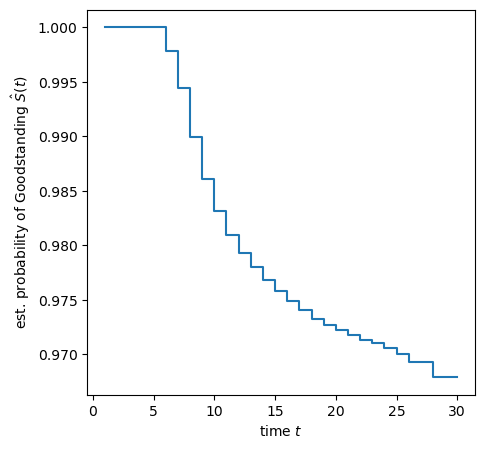

In [247]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["GoodStanding_in_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of Goodstanding $\hat{S}(t)$")
plt.xlabel("time $t$")

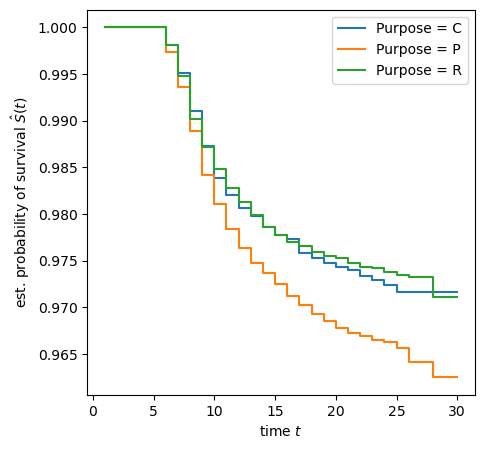

In [249]:
# look at loans by the purpose group
for purchase_type in ("C", "P", "R"):
    mask_purchase = df_mod["PURPOSE"] == purchase_type
    time_purchase, survival_prob_purchase = kaplan_meier_estimator(
        data_y["Status"][mask_purchase],
        data_y["GoodStanding_in_months"][mask_purchase])

    plt.step(time_purchase, survival_prob_purchase, where="post",
             label="Purpose = %s" % purchase_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

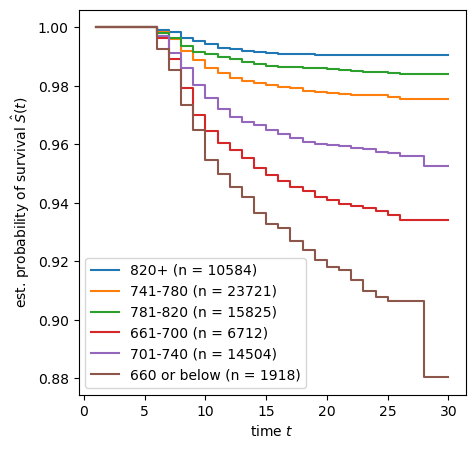

In [250]:
# look at the fico band
for value in df_mod["fico_band"].unique():
    mask = df_mod["fico_band"] == value
    time_ficoband, survival_prob_ficoband = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["GoodStanding_in_months"][mask])
    plt.step(time_ficoband, survival_prob_ficoband, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")